<a href="https://colab.research.google.com/github/gumdropsteve/intro_to_machine_learning/blob/main/day_12/02_pca_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Additional Imports here
import seaborn as sns
import matplotlib.pyplot as plt

# train test split 
from sklearn.model_selection import train_test_split

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Scalers
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

#Grid Search
from sklearn.model_selection import GridSearchCV


<center><H1>PCA With Diabetes Dataset</H1></center>

<p align="center">
  <img width="500" height="200" src="https://i.gifer.com/H7zW.gif">
</p>


👉🏼 [Data Dictionary](https://www.kaggle.com/uciml/pima-indians-diabetes-database) 👈🏼

<center><H3>Steps (Must be performed in this order)</H></center>

1. [Split Data](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
2. EDA (Show us your opinion of the 2 best plots explaining the most important insights int the data). 
    - **Plots Require**:
        - Title
        - Axis Labels
        - Legend
        - A short explanation why it is important as if you were explaining it to someone who has never seen the plot before and is unfamiliar with the data.
3. Determine Baseline Model
4. [Scale Data](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
5. [Create Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
6. Compare Results to Baseline
7. [Perform PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
8. Use Your Principal Components for a Logistic Regression Model
9. Compare Results to Baseline and previous Logistic Regression Model without PCA and provide an explanation of what the results mean and the point of PCA

✨BONUS✨
 - Create a Scree Plot (You will probably have to research this)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/mpHarm88/datasets/master/diabetes.csv")
df.sample(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
33,6,92,92,0,0,19.9,0.188,28,0
270,10,101,86,37,0,45.6,1.136,38,1
43,9,171,110,24,240,45.4,0.721,54,1


In [3]:
# 768 so , we will divide to train and test because we have to less rows 
df.shape

(768, 9)

### Split Data

In [4]:
# split to train & test 

train,test = train_test_split(
    df,
    train_size=0.8, 
    random_state=42)

### EDA

![](https://www.cdc.gov/healthyweight/images/assessing/bmi-adult-fb-600x315.jpg)

### First EDA

In [5]:
#See the heigher mean for the top 10 BMI for each age.

#group with Age and take the mean with BMI sort to take the first 10 and reset the index
train_mean = train.groupby(["Age"]).BMI.mean().sort_values(ascending=False).head(10).reset_index()

We can see people with age 43 has the highest mean for obesity.<br />
Also , people with 40's have higher mean than others.

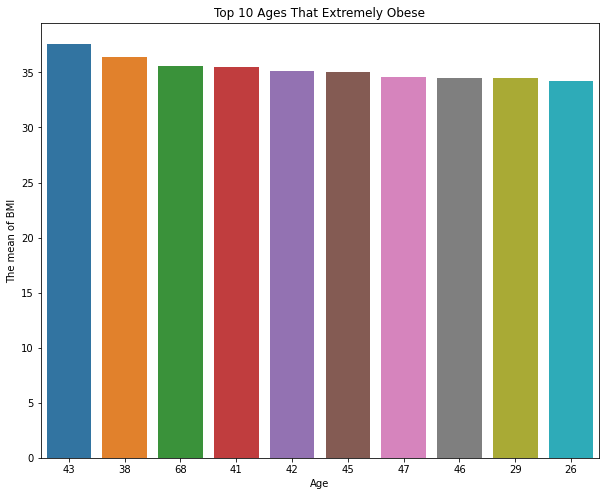

In [6]:
plt.figure(figsize = (10,8))
sns.barplot(
    data=train_mean, 
    x="Age",
    y="BMI",
    order=train_mean.sort_values('BMI',ascending = False).Age
    
)

plt.title("Top 10 Ages That Extremely Obese")
plt.ylabel("The mean of BMI") # x axis label
plt.xlabel("Age") # y axis label
plt.show()

### Second EDA

![](https://i0.wp.com/images-prod.healthline.com/hlcmsresource/images/topic_centers/2018-10/9842-blood-pressure-readings-explained-1296x1645-body.20181002181105178.jpg?w=1155&h=3454)

In [7]:
# in the dataset we use Diastolic blood pressure 

#take the people that have blood pressure less than 80
normal_elevated = train[train["BloodPressure"]< 80]

#take the people that have high blood pressure stage 1
high_bp_stage_1 = high_bp_stage_2 = train[(train["BloodPressure"]> 79) & (train["BloodPressure"]<= 89)]


#take the people that have high blood pressure stage 2
high_bp_stage_2 = train[(train["BloodPressure"]> 89) & (train["BloodPressure"]<= 120)]


# take the people that have hypertensive
hypertensive = train[train["BloodPressure"]> 120]


#group with BloodPressure and take the mean with BMI and reset the index for each group

normal_elevated_mean = normal_elevated.groupby(["BloodPressure"]).BMI.mean().sort_values(ascending=False).reset_index()
high_bp_stage_1_mean = high_bp_stage_1.groupby(["BloodPressure"]).BMI.mean().sort_values(ascending=False).reset_index()
high_bp_stage_2_mean = high_bp_stage_2.groupby(["BloodPressure"]).BMI.mean().sort_values(ascending=False).reset_index()
hypertensive_mean = hypertensive.groupby(["BloodPressure"]).BMI.mean().sort_values(ascending=False).reset_index()


In [8]:
# take the mean for each one and create the label value
BMI_mean = [normal_elevated_mean["BMI"].mean(), 
            high_bp_stage_1_mean["BMI"].mean(), 
            high_bp_stage_2_mean["BMI"].mean(),
            hypertensive_mean["BMI"].mean(),
           ]
# label and x-axis
labels = ["Normal & Elevated", "High Blood Pressure Stage 1",
          "High Blood Pressure Stage 2", "Hypertensive Crisis"]

Here we see while people gain more weight, blood pressure will increase. <br />
For Hypertensive Crisis , here the dataset has just have one value with blood pressure more than 120, so , this is why we see it lower than others.

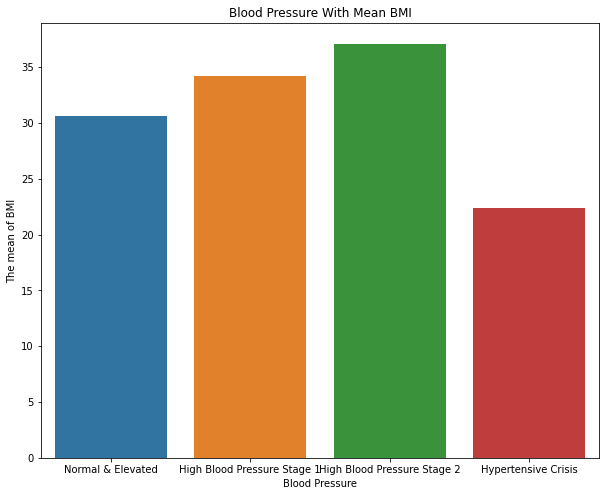

In [9]:
plt.figure(figsize = (10,8))
sns.barplot(
    x=labels,
    y=BMI_mean,
    
)

plt.title("Blood Pressure With Mean BMI")
plt.ylabel("The mean of BMI") # x axis label
plt.xlabel("Blood Pressure") # y axis label
plt.show()

# Now this secion for diabetes

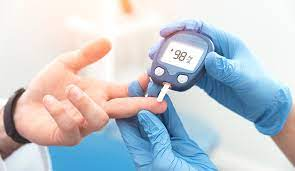

### Determine Baseline Model

In [10]:
# make X , y for train and test 
X_train = train.drop(["Outcome"], axis = 1)
y_train = train["Outcome"]

X_test = test.drop(["Outcome"], axis = 1)
y_test = test["Outcome"]

#### Baseline is 65%

In [11]:
# This is the baseline 
y_train.value_counts(normalize=True)

0    0.653094
1    0.346906
Name: Outcome, dtype: float64

### Scale Data & Logistic Regression Model

In [12]:
# Create a Pipeline
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

0.7532467532467533

## Compare Results to Baseline
Basline : 65% <br/>
LRM without PCA : 75%

# Perform PCA for Logistic Regression Model

In [13]:
# Create a Pipeline and create PCA
pipe_with_pca = make_pipeline(
    StandardScaler(),
    PCA(),
    LogisticRegression()
)

In [14]:
#GridSearchCV
param_grid = {
    "standardscaler__with_mean": [True, False], 
    "standardscaler__with_std": [True, False],
    "pca__n_components": [1,2,3,4,5,6,7,8], # 8  components explains the most variance
    "logisticregression__C": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    "logisticregression__max_iter": [100, 500, 1000, 2000, 2500]
}

grid = GridSearchCV(
    pipe_with_pca, 
    param_grid=param_grid, 
    cv=5, 
    verbose=1, # Higher number means the training step show more output
    n_jobs=-1 # Use all available cores on my computer 
)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2664 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 5464 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   20.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.9, 0.8, 0.7, 0.6, 0.5,
                                                   0.4, 0.3, 0.2, 0.1],
                         'logisticregression__max_iter': [100, 500, 1000, 2000,
                                                          2500],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]},
             verbose=1)

In [15]:
# Best Parameters
grid.best_params_

{'logisticregression__C': 0.2,
 'logisticregression__max_iter': 100,
 'pca__n_components': 8,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': False}

In [16]:
grid.best_score_

0.7687724910035986

## Compare Results to Baseline and LRM with and without PCA
Basline : 65.30% <br/>
LRM without PCA : 75.32% <br/>
LRM with PCA : 76.87% <br/>

# PCA :
- improve the running time
- Use 8 in n_component which means it use all features.
- We see so littile bit improvment but for me i'll use smaller features and to get close result



# Create a Scree Plot

In [18]:
pca = PCA()
pca.fit(X_train)

PCA()

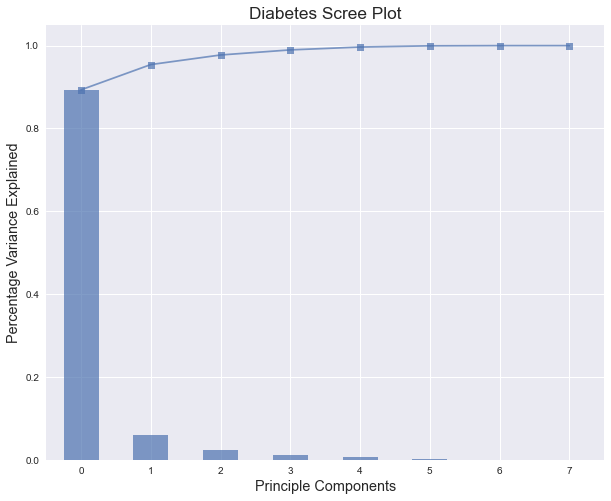

In [19]:
#This is the Scree Plot 

plt.style.use("seaborn")
plt.figure(figsize=(10,8))

exp_var = pd.Series(pca.explained_variance_ratio_) 
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)

pd.Series(var_ls).plot(marker="s", alpha=0.7) #plot line chart of increasing variances
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Diabetes Scree Plot", fontsize="xx-large")
plt.show();

### i'll perform the model again with 3 features 

In [20]:
#GridSearchCV
param_grid_2 = {
    "standardscaler__with_mean": [True, False], 
    "standardscaler__with_std": [True, False],
    "pca__n_components":[3], # 8  components explains the most variance
    "logisticregression__C": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    "logisticregression__max_iter": [100, 500, 1000, 2000, 2500]
}

grid_2 = GridSearchCV(
    pipe_with_pca, 
    param_grid=param_grid_2, 
    cv=5, 
    verbose=1, # Higher number means the training step show more output
    n_jobs=-1 # Use all available cores on my computer 
)

grid_2.fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.9, 0.8, 0.7, 0.6, 0.5,
                                                   0.4, 0.3, 0.2, 0.1],
                         'logisticregression__max_iter': [100, 500, 1000, 2000,
                                                          2500],
                         'pca__n_components': [3],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]},
             verbose=1)

In [21]:
# Best Parameters
grid_2.best_params_

{'logisticregression__C': 1,
 'logisticregression__max_iter': 100,
 'pca__n_components': 3,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': False}

In [22]:
grid_2.best_score_

0.7263627882180461

It is 72.63% which is littile bit close from the previous one  